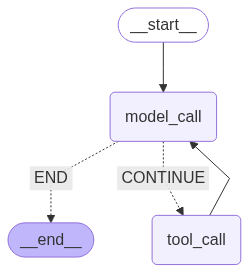

In [5]:
from tools.status_stagChanges import git_add, git_status
from agent import model
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, BaseMessage, ToolCall
from typing import TypedDict, Annotated, List
from langchain_core.tools import tool

# Loading the LLM model
model = model.llm()

# StageGraph of the agent
class AgentState(TypedDict):
    messages : Annotated[List[BaseMessage], lambda x,y : x+y]
    
tools = [git_add, git_status]
model_with_tools = model.bind_tools(tools=tools)


# Deciding the graph and nodes
# Checking the conditional Edge
def should_continue(state: AgentState):
    """Decides whether to continue with a tool call or end the process."""
    print("---ROUTING---")
    last_message = state['messages'][-1]
    if not last_message.tool_calls:
        print("---DECISION: END---")
        return "END"
    else:
        print("---DECISION: CONTINUE TO TOOL---")
        return "CONTINUE"
    
    
# Calling the model
def model_call(state: AgentState):
    """Invokes the model with the current state."""
    print("---THINKING---")
    response = model_with_tools.invoke(state['messages'])
    print(f"Agent : {response.content}")
    return {"messages": [response]}

# Calling the tool
def tool_call(state: AgentState):
    """Executes the tool chosen by the model."""
    print("---EXECUTING TOOL---")
    last_message = state['messages'][-1]
    
    # Ensure there are tool calls to process
    if not last_message.tool_calls:
        return {"messages": []} # Should not happen if routed correctly, but good practice
        
    action = last_message.tool_calls[0]
    
    # Find and invoke the correct tool
    tool_to_call = next((t for t in tools if t.name == action["name"]), None)
    if tool_to_call is None:
        raise ValueError(f"Tool '{action['name']}' not found.")
    
    result = tool_to_call.invoke(action.get("args", {}))
    
    # Create a ToolMessage with the result
    tool_message = ToolMessage(content=str(result), tool_call_id=action["id"])
    print(f"Tool message : {tool_message}")
    
    return {"messages": [tool_message]}


# Wiring the graph
graph = StateGraph(state_schema=AgentState)

graph.add_node("model_call", model_call)
graph.add_node("tool_call", tool_call)

graph.set_entry_point('model_call')

graph.add_conditional_edges(
    source="model_call",
    path=should_continue,
    path_map={
        "CONTINUE" : "tool_call",
        "END" : END
    }
)
graph.add_edge('tool_call', 'model_call')

app = graph.compile()
app